In [25]:
from typing import Dict, Any, List

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node
from architecture.utils import describe_architecture

In [26]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
X_df = dataset_df.drop(columns="class").to_numpy(bool)
y_df = dataset_df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

print("Small dataset shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Small dataset shapes:
X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [38]:
config = dict(
    layer_node_counts=[1024]*3 + [1],      # what if there are more than in the input
    layer_bit_counts=[2]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(X_train, y_train)
pred_test = net.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)
print(f"Accuracy on test set: {acc_test:.6f}")

CPU times: user 2.09 s, sys: 472 ms, total: 2.56 s
Wall time: 10.1 s
Accuracy on test set: 0.668293


In [39]:
def print_architecture(desc: Dict[str, Any]) -> None:
    # inputs are in L0
    input_nodes = {n["name"] for n in desc["layers"][0]["nodes"]}
    used_inputs = sorted({
        b for layer in desc["layers"][1:] for n in layer["nodes"]
        for b in n["backlinks"] if b in input_nodes
    })

    print("Used Inputs:", ", ".join(used_inputs))
    print("Layers & backlinks:")
    for layer in desc["layers"][1:]:  # skip input layer
        print(f"  {layer['name']}: {len(layer['nodes'])} node(s)")
        for n in layer["nodes"]:
            print(f"    {n['name']} - {n['backlinks']}")


desc = describe_architecture(net)
print_architecture(desc)

Used Inputs: L0N0, L0N1, L0N2, L0N3, L0N4, L0N5, L0N6, L0N7, L0N8, L0N9
Layers & backlinks:
  L1: 1024 node(s)
    L1N0 - ['L0N0', 'L0N7']
    L1N1 - ['L0N2']
    L1N2 - ['L0N1', 'L0N4']
    L1N3 - ['L0N0', 'L0N2']
    L1N4 - ['L0N0', 'L0N8']
    L1N5 - ['L0N7', 'L0N9']
    L1N6 - ['L0N3', 'L0N9']
    L1N7 - ['L0N1', 'L0N2']
    L1N8 - ['L0N1', 'L0N6']
    L1N9 - ['L0N3', 'L0N5']
    L1N10 - ['L0N0']
    L1N11 - ['L0N4', 'L0N6']
    L1N12 - ['L0N6', 'L0N9']
    L1N13 - ['L0N6', 'L0N7']
    L1N14 - ['L0N6', 'L0N8']
    L1N15 - ['L0N0', 'L0N6']
    L1N16 - ['L0N6']
    L1N17 - ['L0N1', 'L0N7']
    L1N18 - ['L0N8']
    L1N19 - ['L0N8', 'L0N9']
    L1N20 - ['L0N1', 'L0N8']
    L1N21 - ['L0N6', 'L0N8']
    L1N22 - ['L0N4', 'L0N9']
    L1N23 - ['L0N3']
    L1N24 - ['L0N7', 'L0N9']
    L1N25 - ['L0N3', 'L0N4']
    L1N26 - ['L0N1', 'L0N8']
    L1N27 - ['L0N1', 'L0N2']
    L1N28 - ['L0N0', 'L0N8']
    L1N29 - ['L0N1', 'L0N2']
    L1N30 - ['L0N1', 'L0N4']
    L1N31 - ['L0N5', 'L0N7']
    L1N32 -

In [40]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# --- Global font config: mathtext only (no TeX, no system serif lookup) ---
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def _contrast_color(face_rgba):
    r, g, b, _ = face_rgba
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.5 else 'white'

def format_subscripts(name: str) -> str:
    """Subscript any letter+digits runs, e.g. L2N7 -> $L_{2}N_{7}$."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 120
):
    layers = desc["layers"]

    # --- Collect names per layer ---
    layer_nodes = [[n["name"] for n in layer["nodes"]] for layer in layers]

    # --- Labels (L2N7 -> $N_{7}$, else subscript digits) ---
    pat = re.compile(r"^L\d+N(\d+)$")
    labels = {}
    for nms in layer_nodes:
        for nm in nms:
            m = pat.match(nm)
            lbl = f"N{m.group(1)}" if m else nm
            labels[nm] = format_subscripts(lbl)

    # --- Layer titles ---
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]

    # --- Positions (centered per layer) ---
    pos = {}
    for l, nms in enumerate(layer_nodes):
        k = len(nms)
        if k == 0:
            continue
        ys = (np.arange(k)[::-1] - (k - 1) / 2.0) * node_separation
        xs = np.full(k, l * layer_separation)
        pos.update({nm: (xs[i], ys[i]) for i, nm in enumerate(nms)})

    # --- Graph edges ---
    G = nx.DiGraph()
    G.add_nodes_from(pos)
    for layer in layers[1:]:
        for node in layer["nodes"]:
            tgt = node["name"]
            for src in node.get("backlinks", []):
                if src in pos and tgt in pos:
                    G.add_edge(src, tgt)

    # --- Visual scales & margins ---
    node_diam_pt = max(18.0, node_font_size * 2.4)
    node_size_ptsq = node_diam_pt ** 2
    x_pad = 0.6 * layer_separation
    y_pad = 0.8 * node_separation
    header_offset = 0.6 * node_separation

    # --- Axes extents & figure size ---
    L = max(1, len(layer_nodes))
    all_y = [p[1] for p in pos.values()] or [0.0]
    miny, maxy = min(all_y), max(all_y)
    xmin, xmax = -x_pad, (L - 1) * layer_separation + x_pad
    ymin, ymax = miny - y_pad, maxy + y_pad + header_offset

    SCALE_X_INCH_PER_UNIT = 0.90
    SCALE_Y_INCH_PER_UNIT = 0.86
    figsize = ((xmax - xmin) * SCALE_X_INCH_PER_UNIT,
               (ymax - ymin) * SCALE_Y_INCH_PER_UNIT)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    face = ax.get_facecolor()
    ec = _contrast_color(face)

    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=ec, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(G, pos, node_size=node_size_ptsq,
                           node_color=[face]*len(G), edgecolors=ec,
                           linewidths=edge_width, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=labels,
                            font_size=node_font_size, font_weight="bold", ax=ax)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    # --- Layer headers (single pass) ---
    top_label_y = maxy + y_pad * 0.4 + header_offset
    for l, title in enumerate(layer_titles):
        ax.text(l * layer_separation, top_label_y, title,
                ha="center", va="bottom", color=ec,
                fontweight="bold", fontsize=header_font_size)

    plt.show()

In [41]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net


red_net = reduce_ripper_net(net)
red_net.prune()

pred_test_after = red_net.predict(X_test)

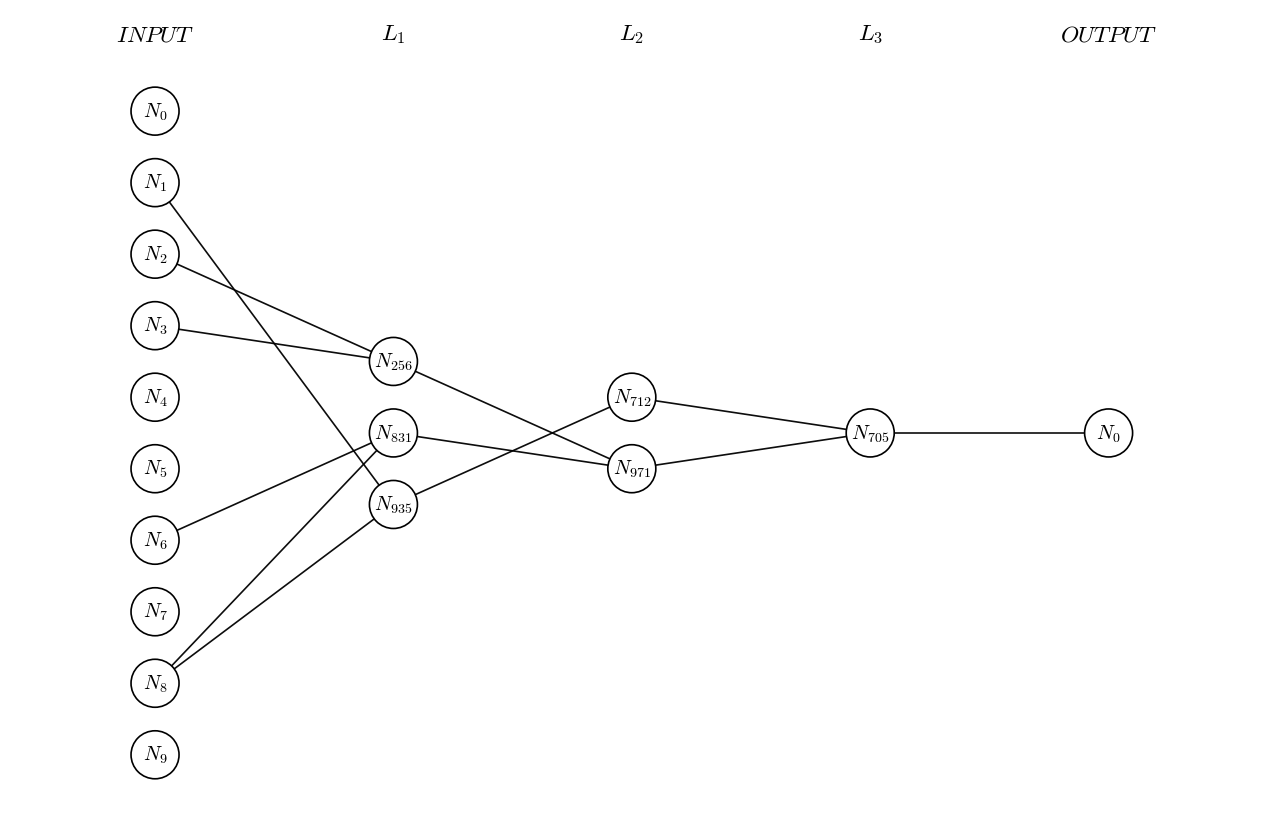

In [42]:
desc_after = describe_architecture(red_net)

plot_architecture_networkx(
    desc_after,
    layer_separation=3,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=1,
)